In [18]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk; nltk.download('stopwords')
import re
from nltk.corpus import stopwords

nltk.download('vader_lexicon')
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.coherencemodel import CoherenceModel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alici\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\alici\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Preprocessing And Feature Engineering (User Reviews)

In [9]:
df = pd.read_csv('../Data Files/Raw Data/users_reviews.csv')
df.head(5)

,UserID,Title,Year,Review_Title,Review
0,ur117926588,Operation Fortune: Ruse de guerre,2023,Guy Ritchie returns to the spy genre with a fu...,"Following a theft of a device known as ""The Ha..."
1,ur117926588,Max,2015,A well made dog adventure story with considera...,"In the Kandahar Province of Afghanistan, Belig..."
2,ur117926588,The Night Agent,2023–,A fun intrigue rich conspiracy thriller anchor...,One year after thwarting a terrorist attack on...
3,ur117926588,New Nightmare,1994,Wes Craven celebrates the 10 year anniversary ...,10 years after the first A Nightmare on Elm St...
4,ur117926588,Freddy's Dead: The Final Nightmare,1991,"The ""final"" entry in the Nightmare on Elm Stre...","10 years in the future, the town of Springwood..."


### Extract sentiment scores from reviews

In [10]:
# Create a SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

# Get the sentiment score as a dictionary with keys 'neg', 'neu', and 'pos'
# and values between 0 and 1 indicating the sentiment intensity

df['sentiment_score'] = df['Review'].apply(lambda x: analyzer.polarity_scores(x)['compound'])
df.head(5)

,UserID,Title,Year,Review_Title,Review,sentiment_score
0,ur117926588,Operation Fortune: Ruse de guerre,2023,Guy Ritchie returns to the spy genre with a fu...,"Following a theft of a device known as ""The Ha...",0.9605
1,ur117926588,Max,2015,A well made dog adventure story with considera...,"In the Kandahar Province of Afghanistan, Belig...",0.9862
2,ur117926588,The Night Agent,2023–,A fun intrigue rich conspiracy thriller anchor...,One year after thwarting a terrorist attack on...,0.9983
3,ur117926588,New Nightmare,1994,Wes Craven celebrates the 10 year anniversary ...,10 years after the first A Nightmare on Elm St...,0.9891
4,ur117926588,Freddy's Dead: The Final Nightmare,1991,"The ""final"" entry in the Nightmare on Elm Stre...","10 years in the future, the town of Springwood...",-0.9821


### Extract topics from review title (Topic Modeling)

Preprocess review title

In [11]:
import gensim
from gensim.utils import simple_preprocess

stop_words = stopwords.words('english')
stop_words.extend(['film', 'movie', 'story'])

def preprocess(df):

    def sent_to_words(sentences):
        for sentence in sentences:
            # deacc=True removes punctuations
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) 
                if word not in stop_words] for doc in texts]

            
    # Remove punctuation
    df['review_processed'] = df['Review_Title'].map(lambda x: re.sub('[,\.!?]', '', x))

    # Convert the titles to lowercase
    df['review_processed'] = df['review_processed'].map(lambda x: x.lower())

    # Print out the first rows of papers
    df['review_processed'].head()

    data = df.review_processed.values.tolist()
    data_words = list(sent_to_words(data))
    # remove stop words
    data_words = remove_stopwords(data_words)
    return data_words

data_words = preprocess(df)
print(data_words[:1][0][:30])

['guy', 'ritchie', 'returns', 'spy', 'genre', 'fun', 'thriller', 'starts', 'great', 'unravels', 'sloppy', 'third', 'act']


In [15]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


Baseline LDA Model and LDA MultiCore

In [13]:
# Build LDA model

lda_model1 = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=15, 
                                           random_state=123,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

lda_model2 =  gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=15,  random_state=123)

Perplexity - Perplexity as well is one of the intrinsic evaluation metric, and is widely used for language model evaluation. It captures how surprised a model is of new data it has not seen before, and is measured as the normalized log-likelihood of a held-out test set.

Topic Coherence - Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.

In [45]:

# Compute Perplexity
print('\nPerplexity for LDAModel: ', lda_model1.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_lda1 = CoherenceModel(model=lda_model1, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
print('\nCoherence Score for LDAModel: ', coherence_lda1)


# Compute Perplexity
print('\nPerplexity for LDAMultiCore: ', lda_model2.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
coherence_lda2 = CoherenceModel(model=lda_model2, texts=data_words, dictionary=id2word, coherence='c_v').get_coherence()
print('\nCoherence Score for LDAMultiCore: ', coherence_lda2)


Perplexity for LDAModel:  -17.29048947970599

Coherence Score for LDAModel:  0.5407637423073592

Perplexity for LDAMultiCore:  -9.51304142701111

Coherence Score for LDAMultiCore:  0.40835160618367683


Since coherence score for LDA model is higher than LDAMultiCore, we will be using the LDAModel 

Evaluating Topic models

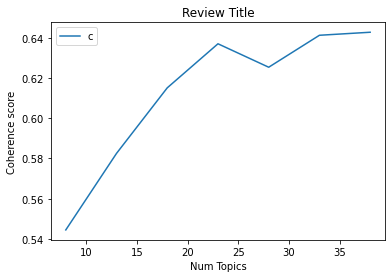

In [20]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =  gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words, start=8, limit=40, step=5)

# Show graph
limit=40; start=8; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.title("Review Title")
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [28]:
from pprint import pprint

# Build LDA model
lda_model_final = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=23, 
                                           random_state=123)
# # Print the Keyword in the 10 topics
# pprint(lda_model_final.print_topics())
doc_lda = lda_model_final[corpus]

In [35]:
pd.set_option('display.max_colwidth', -1)
topics = [[(term, round(wt, 3)) for term, wt in lda_model_final.show_topic(n, topn=20)] for n in range(0, lda_model_final.num_topics)]
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, lda_model_final.num_topics+1)] )
topics_df

c:\Users\alici\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


,Terms per Topic
Topic1,"great, decent, two, watching, lot, far, slow, thriller, super, still, gangster, adaptation, heist, good, bland, screen, novel, musical, memorable, cliche"
Topic2,"entertaining, like, despite, title, clever, excellent, care, dream, blood, sense, anything, nice, humor, needs, seems, early, faithful, guys, popular, twists"
Topic3,"well, made, even, least, korean, favorite, might, beautiful, war, special, one, think, never, overall, expect, saying, mind, sequences, iron, put"
Topic4,"horror, original, though, little, cool, amazing, times, end, trilogy, fantasy, mystery, always, look, starts, world, begins, history, fall, execution, left"
Topic5,"watch, watchable, go, forgettable, tedious, let, simple, real, disturbing, believe, attention, anyone, men, charm, serious, wild, baby, gritty, picture, spectacular"
Topic6,"really, boring, around, thought, know, second, new, want, hilarious, basically, trying, instead, superheroes, time, kid, need, tedious, teen, stop, dance"
Topic7,"fun, funny, nothing, seeing, elements, man, age, enough, human, coming, grand, charming, experience, sweet, stand, cop, thrilling, mostly, comedic, engaging"
Topic8,"dull, start, zombie, hard, video, sad, effective, kids, road, psychological, character, awful, perfect, girl, near, poor, study, thriller, ride, give"
Topic9,"love, somewhat, get, back, something, work, straight, dumb, hollywood, comes, solid, weak, effort, making, together, ass, standard, white, waste, cast"
Topic10,"style, see, going, book, either, plot, goes, lacks, bonding, characters, fighting, taken, street, hell, society, magic, strange, hit, convoluted, development"


In [38]:
pd.reset_option('all')
# Get topic labels for each document
topic_labels = [max(lda_model_final[doc], key=lambda x:x[1])[0] for doc in corpus]
len(topic_labels)

As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.

: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.



c:\Users\alici\anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: As the xlwt package is no longer maintained, the xlwt engine will be removed in a future version of pandas. This is the only engine in pandas that supports writing in the xls format. Install openpyxl and write to an xlsx file instead.
  warnings.warn(d.msg, FutureWarning)
c:\Users\alici\anaconda3\lib\site-packages\pandas\_config\config.py:630: FutureWarning: 
: boolean
    use_inf_as_null had been deprecated and will be removed in a future
    version. Use `use_inf_as_na` instead.

  warnings.warn(d.msg, FutureWarning)


12770

In [44]:
df['topic_labels'] = topic_labels
df['topic_keywords'] = df.topic_labels.apply(lambda x: [word for word, prob in lda_model_final.show_topic(x)])
df.head(5)

,UserID,Title,Year,Review_Title,Review,sentiment_score,review_processed,topic_labels,topic_keywords
0,ur117926588,Operation Fortune: Ruse de guerre,2023,Guy Ritchie returns to the spy genre with a fu...,"Following a theft of a device known as ""The Ha...",0.9605,guy ritchie returns to the spy genre with a fu...,10,"[good, enjoyable, thriller, almost, spy, engro..."
1,ur117926588,Max,2015,A well made dog adventure story with considera...,"In the Kandahar Province of Afghanistan, Belig...",0.9862,a well made dog adventure story with considera...,2,"[well, made, even, least, korean, favorite, mi..."
2,ur117926588,The Night Agent,2023–,A fun intrigue rich conspiracy thriller anchor...,One year after thwarting a terrorist attack on...,0.9983,a fun intrigue rich conspiracy thriller anchor...,0,"[great, decent, two, watching, lot, far, slow,..."
3,ur117926588,New Nightmare,1994,Wes Craven celebrates the 10 year anniversary ...,10 years after the first A Nightmare on Elm St...,0.9891,wes craven celebrates the 10 year anniversary ...,20,"[drama, life, classic, actually, crime, year, ..."
4,ur117926588,Freddy's Dead: The Final Nightmare,1991,"The ""final"" entry in the Nightmare on Elm Stre...","10 years in the future, the town of Springwood...",-0.9821,"the ""final"" entry in the nightmare on elm stre...",5,"[really, boring, around, thought, know, second..."


In [43]:
df = pd.read_csv('../Data Files/Raw Data/users_ratings.csv')
df.head(5)

,UserID,Title,Year,Description,Directors,Stars,Viewer_Advisory,Duration,Genre,Votes,Movie_Rating,User_Rating
0,ur117926588,A Nightmare on Elm Street 2: Freddy's Revenge,1985,A teenage boy is haunted in his dreams by dece...,['Jack Sholder'],"['Robert Englund', 'Mark Patton', 'Kim Myers',...",R,1 hr 27 min,Horror,72454.0,5.4,5
1,ur117926588,Elvis,2022,The life of American music icon,['Baz Luhrmann'],"['Tom Hanks', 'Austin Butler', 'Olivia DeJonge...",PG-13,2 hr 39 min,"Biography, Drama, Music",196677.0,7.3,8
2,ur117926588,Where Eagles Dare,1968,Allied agents stage a daring raid on a castle ...,['Brian G. Hutton'],"['Richard Burton', 'Clint Eastwood', 'Mary Ure...",M,2 hr 38 min,"Action, Adventure, War",59856.0,7.6,9
3,ur117926588,A Nightmare on Elm Street,1984,Teenager Nancy Thompson must uncover the dark ...,['Wes Craven'],"['Heather Langenkamp', 'Johnny Depp', 'Robert ...",R,1 hr 31 min,Horror,245805.0,7.4,9
4,ur117926588,Eagle Eye,2008,Jerry and Rachel are two strangers thrown toge...,['D.J. Caruso'],"['Shia LaBeouf', 'Michelle Monaghan', 'Rosario...",PG-13,1 hr 58 min,"Action, Mystery, Thriller",189895.0,6.6,5


In [44]:
import re

# Remove punctuation
df['desc_processed'] = df['Description'].map(lambda x: re.sub('[,\.!?]', '', str(x)))

# Convert the titles to lowercase
df['desc_processed'] = df['desc_processed'].map(lambda x: x.lower())

# Print out the first rows of papers
df['desc_processed'].head()

<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<ipython-input-44-3147a844635c>:4: DeprecationWarning: invalid escape sequence \.
  df['desc_processed'] = df['Description'].map(lambda x: re.sub('[,\.!?]', '', str(x)))


0    a teenage boy is haunted in his dreams by dece...
1                      the life of american music icon
2    allied agents stage a daring raid on a castle ...
3    teenager nancy thompson must uncover the dark ...
4    jerry and rachel are two strangers thrown toge...
Name: desc_processed, dtype: object

In [45]:
data = df.desc_processed.values.tolist()
data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)
print(data_words[:1][0][:30])

['teenage', 'boy', 'haunted', 'dreams', 'deceased', 'child', 'murderer', 'freddy', 'krueger', 'possess', 'order', 'continue', 'reign', 'terror', 'real', 'world']


In [48]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts2 = data_words
# Term Document Frequency
corpus2 = [id2word.doc2bow(text) for text in texts2]
# View
print(corpus2[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1)]


In [50]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus2,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.005*"life" + 0.005*"new" + 0.005*"young" + 0.005*"man" + 0.005*"two" + '
  '0.004*"son" + 0.004*"find" + 0.004*"becomes" + 0.003*"love" + '
  '0.003*"family"'),
 (1,
  '0.007*"wife" + 0.006*"new" + 0.006*"becomes" + 0.006*"young" + 0.006*"man" '
  '+ 0.005*"woman" + 0.005*"life" + 0.004*"two" + 0.004*"group" + '
  '0.004*"finds"'),
 (2,
  '0.007*"story" + 0.006*"man" + 0.005*"young" + 0.005*"two" + 0.005*"war" + '
  '0.005*"american" + 0.005*"one" + 0.004*"family" + 0.004*"world" + '
  '0.004*"woman"'),
 (3,
  '0.008*"young" + 0.007*"new" + 0.007*"one" + 0.006*"life" + 0.005*"two" + '
  '0.005*"world" + 0.005*"family" + 0.004*"murder" + 0.004*"woman" + '
  '0.003*"police"'),
 (4,
  '0.009*"two" + 0.005*"must" + 0.005*"man" + 0.005*"family" + 0.005*"love" + '
  '0.004*"woman" + 0.004*"world" + 0.004*"life" + 0.004*"school" + '
  '0.004*"three"'),
 (5,
  '0.014*"new" + 0.009*"young" + 0.008*"man" + 0.006*"must" + 0.005*"life" + '
  '0.005*"love" + 0.005*"york" + 0.004*"friends"